In [1]:
%matplotlib inline
%matplotlib notebook

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from DQN import DQN
from EpsilonGreedyStrategy import EpsilonGreedyStrategy
from Experience import Experience
from ReplayMemory import ReplayMemory
from CartPoleEnvManager import CartPoleEnvManager
from Agent import Agent
import Utils
from QValues import QValues



In [2]:
batch_size = 256
gamma = 0.999 # discount factor for Bellman equation
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000
max_steps_per_episode = 200

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # no grad calculation needed for second net

optimizer = optim.Adam(params = policy_net.parameters(), lr=lr)



In [4]:
print(em.num_actions_available())

2


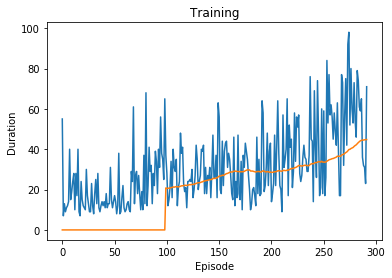

Episode 292 
 100 episode moving avg: 44.8


In [ ]:
episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    #  For each episode, we first reset the environment, then get the initial state.
    # Now, we'll step into the nested for loop that will iterate over each time step within each episode. 
    #for timestep in count():
    for timestep in range(max_steps_per_episode):
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = Utils.extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if em.done:
                episode_durations.append(timestep)
                Utils.plot(episode_durations, 100)
                break
            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
                
            
em.close()            